Transfer learning can be performed in two ways:
1. Fine Tuning
2. Feature Extractor

This notebook implements and compares both techniques on the Hymenoptera dataset in Pytorch.

**TLDR**: Feature Extractor provides the highest validation accuracy of 0.9542 while Fine-tuning the model provides an accuracy of 0.9411. 

This can be attributed to the lesser amount of data in Hymenoptera dataset as compared to the ImageNet dataset, whose pretrained layers extracted features more accurately.

## Import Libraries

In [1]:
import numpy as np
import os
import copy

# Data Visualisation and Preprocessing
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

# Model training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

## Load Data

In [2]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip 

--2022-11-09 18:36:51--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.172.170.53, 18.172.170.43, 18.172.170.106, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.172.170.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   142MB/s    in 0.3s    

2022-11-09 18:36:52 (142 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_dat

In [15]:
# Preprocess and Augment data by cropping the image, randomly flipping it and normalising it. 
# Images are also converted to tensors before being passed through the model. 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# Define data directory
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Load data
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
print(class_names)

{'train': 244, 'val': 153}
['ants', 'bees']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Data Visualization

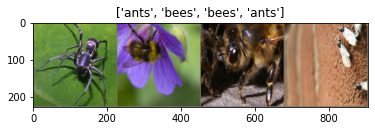

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## Function to Train Model

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 1. Fine tune Model

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [11]:
model_ft = train_model(model_ft,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5717 Acc: 0.7336
val Loss: 0.1935 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.4880 Acc: 0.7992
val Loss: 0.1855 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.3840 Acc: 0.8320
val Loss: 0.1557 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.3686 Acc: 0.8279
val Loss: 0.1697 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.2579 Acc: 0.9098
val Loss: 0.1800 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3424 Acc: 0.8525
val Loss: 0.2056 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.3272 Acc: 0.8566
val Loss: 0.1765 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3125 Acc: 0.8689
val Loss: 0.1800 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3463 Acc: 0.8648
val Loss: 0.2112 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.2476 Acc: 0.8811
val Loss: 0.1936 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2954 Acc: 0.8566
val Loss: 0.1794 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2757 Acc: 0.9016
val Loss: 0.1772 Acc: 0.9281

Ep

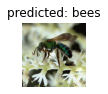

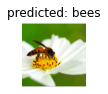

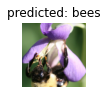

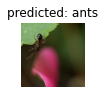

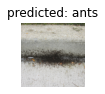

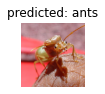

In [10]:
visualize_predictions(model_ft)

## 2. Feature extractor

In [23]:
model_conv = torchvision.models.resnet18(pretrained=True)

# We freeze layers here
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [24]:
model_conv = train_model(model_conv,
                         criterion,
                         optimizer_conv,
                         exp_lr_scheduler,
                         num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5998 Acc: 0.6434
val Loss: 0.2613 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4218 Acc: 0.8074
val Loss: 0.2850 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.4605 Acc: 0.7828
val Loss: 0.1774 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4745 Acc: 0.8074
val Loss: 0.2873 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.4871 Acc: 0.7910
val Loss: 0.2147 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4049 Acc: 0.8238
val Loss: 0.1874 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4583 Acc: 0.8197
val Loss: 0.1833 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.4472 Acc: 0.8033
val Loss: 0.2202 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3259 Acc: 0.8566
val Loss: 0.1818 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.4123 Acc: 0.8238
val Loss: 0.1924 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3413 Acc: 0.8361
val Loss: 0.1784 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4038 Acc: 0.8320
val Loss: 0.1846 Acc: 0.9542

Ep

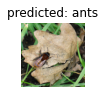

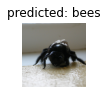

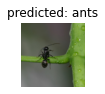

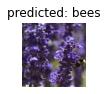

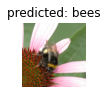

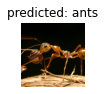

In [18]:
visualize_predictions(model_conv)